In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from math import sqrt
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras import callbacks
import tensorflow as tf
tf.__version__
#倒入一些必要的库

Using TensorFlow backend.


'1.15.0'

In [2]:
feanum=4#一共有多少特征
window=5#时间窗设置
df1=pd.read_csv('data.csv') #读取数据，0对应第一支股票，1对应第二只，以此类推
df1=df1.iloc[100:-1,1:5]#选取从第3600行开始的数据 大概是2006年一月
df1.tail()

,open,high,low,close
6523,2929.8,2933.4,2926.8,2927.9
6524,2927.6,2929.2,2924.7,2928.5
6525,2928.5,2929.4,2927.4,2929.4
6526,2929.4,2934.7,2929.3,2933.9
6527,2933.7,2934.9,2932.6,2933.4


In [3]:
from sklearn import preprocessing#进行归一化操作
min_max_scaler = preprocessing.MinMaxScaler()
df0=min_max_scaler.fit_transform(df1)
df = pd.DataFrame(df0, columns=df1.columns)
df.tail()

,open,high,low,close
6423,0.495569,0.496220,0.497847,0.497626
6424,0.493102,0.491481,0.495467,0.498304
6425,0.494111,0.491707,0.498527,0.499322
6426,0.495121,0.497687,0.500680,0.504409
6427,0.499944,0.497913,0.504420,0.503844


In [4]:
#技术问题 重新对列做一个排序
order = ['open', 'high', 'low', 'close']
df = df[order]
df.tail()

,open,high,low,close
6423,0.495569,0.496220,0.497847,0.497626
6424,0.493102,0.491481,0.495467,0.498304
6425,0.494111,0.491707,0.498527,0.499322
6426,0.495121,0.497687,0.500680,0.504409
6427,0.499944,0.497913,0.504420,0.503844


In [5]:
#这一部分在处理数据 将原始数据改造为LSTM网络的输入
stock=df
seq_len=window
amount_of_features = len(stock.columns)#有几列


In [6]:
amount_of_features

4

In [78]:
data = stock.values #pd.DataFrame(stock)表格转化为矩阵

sequence_length = seq_len + 1#序列长度+1
result = []
for index in range(len(data) - sequence_length):#循环 数据长度-时间窗长度 次
    result.append(data[index: index + sequence_length])#第i行到i+5
result = np.array(result)#得到样本，样本形式为 window*feanum
cut=800#分训练集测试集 最后cut个样本为测试集
train = result[:-cut, :]
x_train = train[:, :-1]
y_train = train[:, -1][:,-1]
x_test = result[-cut:, :-1]
y_test = result[-cut:, -1][:,-1]
X_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
X_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

In [79]:
#展示下训练集测试集的形状 看有没有问题
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (5622, 5, 4)
y_train (5622,)
X_test (800, 5, 4)
y_test (800,)


D:\Anaconda\envs\wcxenv\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, activation="relu", kernel_initializer="uniform")`
  
D:\Anaconda\envs\wcxenv\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':
D:\Anaconda\envs\wcxenv\lib\site-packages\ipykernel_launcher.py:12: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if sys.path[0] == '':


Epoch 1/50
5622/5622 [==============================] - 14s 2ms/step - loss: 0.1884
Epoch 2/50
5622/5622 [==============================] - 1s 228us/step - loss: 0.1007
Epoch 3/50
5622/5622 [==============================] - 1s 225us/step - loss: 0.0384
Epoch 4/50
5622/5622 [==============================] - 1s 230us/step - loss: 0.0132
Epoch 5/50
5622/5622 [==============================] - 1s 230us/step - loss: 0.0028
Epoch 6/50
5622/5622 [==============================] - 1s 232us/step - loss: 0.0011
Epoch 7/50
5622/5622 [==============================] - 1s 232us/step - loss: 8.6704e-04
Epoch 8/50
5622/5622 [==============================] - 1s 231us/step - loss: 7.0769e-04
Epoch 9/50
5622/5622 [==============================] - 1s 238us/step - loss: 6.5199e-04
Epoch 10/50
5622/5622 [==============================] - 1s 233us/step - loss: 6.4064e-04
Epoch 11/50
5622/5622 [==============================] - 1s 235us/step - loss: 5.8727e-04
Epoch 12/50
5622/5622 [=====================

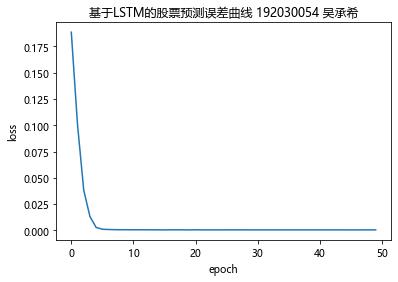

In [98]:
#建立、训练模型过程
d = 0.038#学习率
model = Sequential()#建立层次模型
model.add(LSTM(64, input_shape=(window, feanum), return_sequences=True))#建立LSTM层
model.add(Dropout(d))#建立的遗忘层
model.add(LSTM(16, input_shape=(window, feanum), return_sequences=False))#建立LSTM层
model.add(Dropout(d))#建立的遗忘层
model.add(Dense(4,init='uniform',activation='relu'))   #建立全连接层     
model.add(Dense(1,init='uniform',activation='relu'))
model.compile(loss='mse',optimizer='adam')

hhh = model.fit(X_train, y_train, nb_epoch =50, batch_size = 200)#训练模型nb_epoch次
# hhh.histoy
plt.plot(hhh.history['loss'])
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('基于LSTM的股票预测误差曲线 192030054 吴承希')
# plt.plot(hhh.history['acc'])
plt.show()

In [99]:
#总结模型
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_83 (LSTM)               (None, 5, 64)             17664     
_________________________________________________________________
dropout_81 (Dropout)         (None, 5, 64)             0         
_________________________________________________________________
lstm_84 (LSTM)               (None, 16)                5184      
_________________________________________________________________
dropout_82 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_78 (Dense)             (None, 4)                 68        
_________________________________________________________________
dense_79 (Dense)             (None, 1)                 5         
Total params: 22,921
Trainable params: 22,921
Non-trainable params: 0
_________________________________________________________________


In [100]:
#在训练集上的拟合结果
y_train_predict=model.predict(X_train)[:,0]
y_train=y_train

Text(0.5, 1.0, 'Train Data 192030054 吴承希')

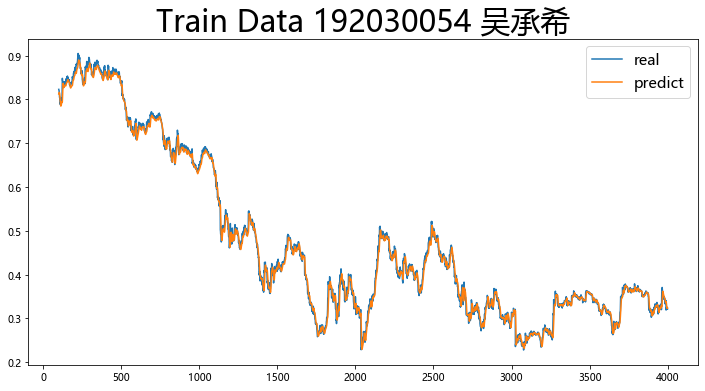

In [101]:
draw=pd.concat([pd.DataFrame(y_train),pd.DataFrame(y_train_predict)],axis=1)
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
draw.iloc[100:4000,0].plot(figsize=(12,6))
draw.iloc[100:4000,1].plot(figsize=(12,6))
plt.legend(('real', 'predict'),loc='upper right',fontsize='15')
plt.title("Train Data 192030054 吴承希",fontsize='30') #添加标题
#展示在训练集上的表现 

In [102]:
#在测试集上的预测
y_test_predict=model.predict(X_test)[:,0]
y_test=y_test

Text(0.5, 1.0, 'Test Data 192030054 吴承希')

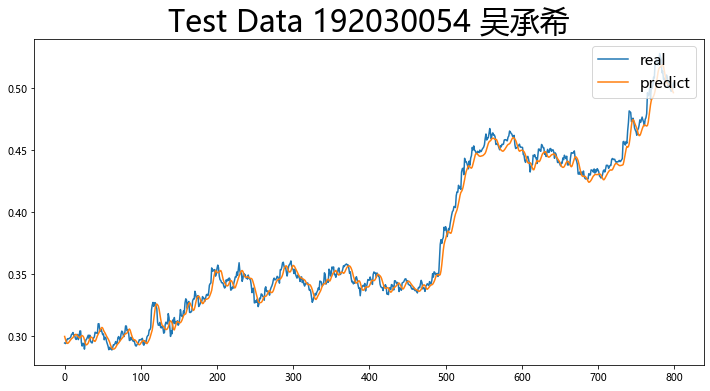

In [103]:
draw=pd.concat([pd.DataFrame(y_test),pd.DataFrame(y_test_predict)],axis=1);
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
draw.iloc[:,0].plot(figsize=(12,6))
draw.iloc[:,1].plot(figsize=(12,6))
plt.legend(('real', 'predict'),loc='upper right',fontsize='15')
plt.title("Test Data 192030054 吴承希",fontsize='30') #添加标题
#展示在测试集上的表现 

In [104]:
#输出结果
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import math
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100
print('训练集上的MAE/MSE/MAPE')
print(mean_absolute_error(y_train_predict, y_train))
print(mean_squared_error(y_train_predict, y_train) )
print(mape(y_train_predict, y_train) )
print('测试集上的MAE/MSE/MAPE')
print(mean_absolute_error(y_test_predict, y_test))
print(mean_squared_error(y_test_predict, y_test) )
print(mape(y_test_predict, y_test) )
y_var_test=y_test[1:]-y_test[:len(y_test)-1]
y_var_predict=y_test_predict[1:]-y_test_predict[:len(y_test_predict)-1]
txt=np.zeros(len(y_var_test))
for i in range(len(y_var_test-1)):
    txt[i]=np.sign(y_var_test[i])==np.sign(y_var_predict[i])
result=sum(txt)/len(txt)
print('预测涨跌正确:',result)

训练集上的MAE/MSE/MAPE
0.007826310084029276
0.00013052449330911093
3.3454850991037834
测试集上的MAE/MSE/MAPE
0.004954805749117102
4.129043991847362e-05
1.3279982902080745
预测涨跌正确: 0.45431789737171463
